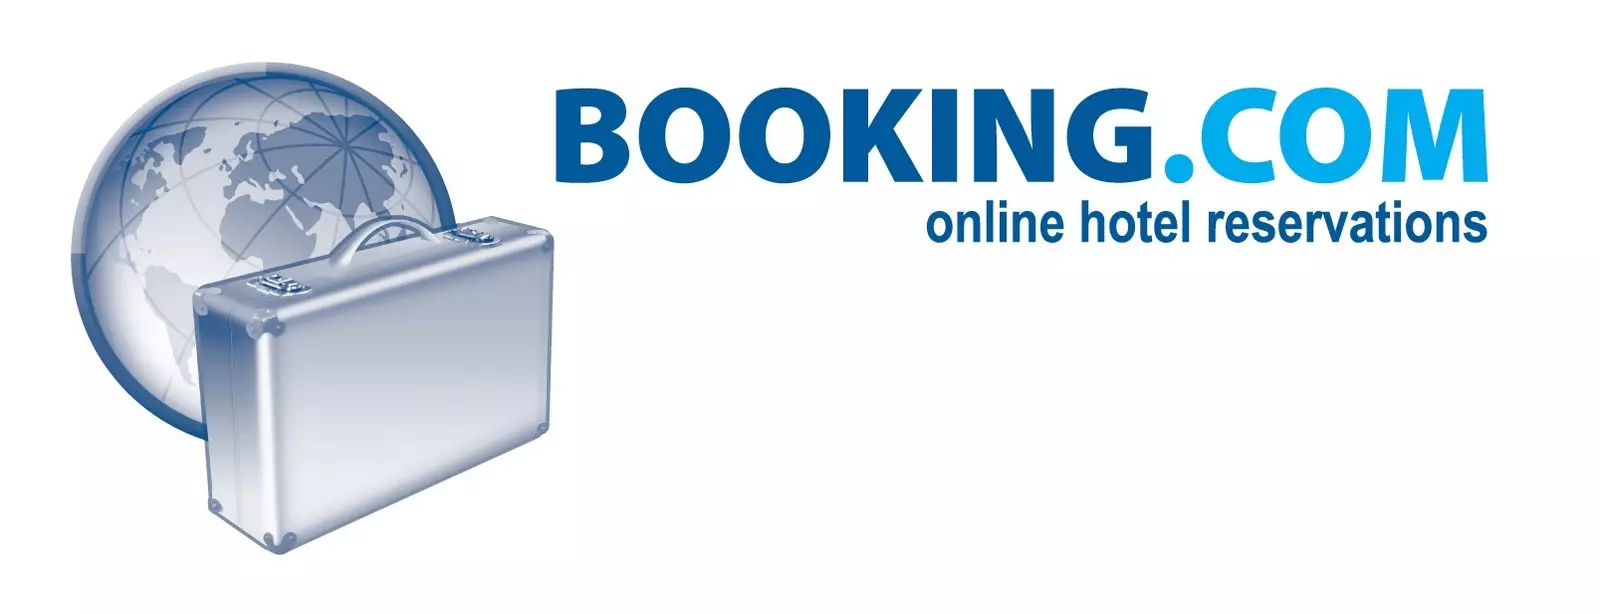

# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle (Jupiter notebook для Kaggle)

#### Леонтьев Петр (поток DSPR-155)   

## Оглавление <a id="item-zero"></a>


- [**1. Problem (Проблема**)](#item-one)
- [**2. Collection (Сбор данных)**](#item-two)
- [**3. EDA: Исследовательский анализ данных**](#item-three)
- [**4. Feature Engineering (Проектирование признаков)**](#item-four)
- [**5. Анализ тональности текстов**](#item-five)
- [**6. Обработка категориальных признаков**](#item-six)
- [**7. Подготовка данных для модели**](#item-seven)
- [**8. Обучение модели RandomForestRegressor**](#item-eight)
- [**9. Обучение модели LightGBM**](#item-nine)
- [**10. Выводы**](#item-ten)
- [**11.Проведем подбор гиперпараметров для модели**](#item-eleven)
- [**12.Обучение финальной модели с лучшими параметрами**](#item-twelve)
- [**13.Окончательное сравнение моделей: RandomForest → LightGBM → LightGBM (тюнинг)**](#item-thirteen)

## Predict HotelBooking Rating

# 1. Problem(Проблема) <a id="item-one"></a>

#### Проблема:

Одна из проблем компании Booking.com — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

[Оглавление ⬆️](#item-zero)

#### Цель проекта:

**Построить модель на основе алгоритма машинного обучения - RandomForestRegressor, которая предсказывает рейтинг отеля.**

#### Задачи проекта:

1. Ознакомиться с входными данными;
2. Изучить пример машинного обучения (scikit-learn класс RandomForestRegressor);
3. Выполнить подготовку данных, которые будут использованы для обучения модели;
4. Проверить эффективность предлагаемой модели, используя метрику MAPE;
5. Принять участие в соревнованиях на площадке Kaggle (kaggle.com).

## 2. Collection(Сбор данных) <a id="item-two"></a>

### Импорт необходимых библиотек и функций

In [13]:
# --- Импорты ---

# Стандартные библиотеки Python
import os  # для работы с файловой системой
import time  # для измерения времени выполнения

# Библиотеки для работы с данными
import numpy as np  # для работы с массивами и математикой
import pandas as pd  # для анализа и обработки таблиц

# Библиотеки для визуализации
import matplotlib.pyplot as plt  # базовая визуализация
import seaborn as sns  # статистическая визуализация
import plotly.express as px  # интерактивная визуализация

# Библиотеки для подготовки данных
from sklearn.model_selection import train_test_split  # разбиение на train/test
from sklearn.preprocessing import PolynomialFeatures, StandardScaler  # генерация признаков и стандартизация
import category_encoders as ce  # для кодирования категориальных признаков

# Статистические функции
from scipy.stats import normaltest, stats  # тесты нормальности и другие статистические функции
from collections import Counter  # для подсчета частоты элементов

# Обработка текста и анализ тональности
import nltk  # работа с текстом
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # анализ тональности текста

# Модели машинного обучения
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

# Для работы в Jupyter Notebook
try:
    get_ipython().run_line_magic('matplotlib', 'inline')  # отображение графиков внутри ноутбука
except:
    pass

# --- Фиксация случайности для воспроизводимости ---
RANDOM_SEED = 1369

[Оглавление ⬆️](#item-zero)

### **Загружаем данные** 

In [2]:
# --- Проверка наличия файлов и загрузка данных ---
DATA_PATH = "data"
REQUIRED_FILES = ['hotels_train.csv', 'hotels_test.csv', 'submission.csv']

for file in REQUIRED_FILES:
    full_path = os.path.join(DATA_PATH, file)
    assert os.path.exists(full_path), f"Файл не найден: {file}"

hotels_train = pd.read_csv(os.path.join(DATA_PATH, 'hotels_train.csv'))
hotels_test = pd.read_csv(os.path.join(DATA_PATH, 'hotels_test.csv'))
submission_df = pd.read_csv(os.path.join(DATA_PATH, 'submission.csv'))

# --- Предварительный обзор датасетов ---
def preview_dataset(df, name):
    print(f"\nИнформация о датасете {name}:")
    display(df.info())
    display(df.head(1))
    display(df.tail(1))

preview_dataset(hotels_train, "Train")
preview_dataset(hotels_test, "Test")
preview_dataset(submission_df, "Submission")

# --- Предобработка ---
# Добавим признак sample для разделения обучающей и тестовой выборки
hotels_train['sample'] = 1
hotels_test['sample'] = 0

# В тестовой выборке отсутствует целевой признак, временно заполним его нулями
hotels_test['reviewer_score'] = 0

# Объединяем обучающую и тестовую выборки в один датафрейм
hotels_df = pd.concat([hotels_train, hotels_test], ignore_index=True)


Информация о датасете Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                         

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
386802,25 Courtfield Gardens Kensington and Chelsea L...,222,8/5/2016,9.0,The Nadler Kensington,Australia,Patio outside could have been cleaned of alga...,20,1209,Beds comfortable Pillows also good Homely fee...,20,2,8.8,"[' Leisure trip ', ' Couple ', ' Bunk Bed Room...",363 day,51.493109,-0.190208



Информация о датасете Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                          

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
128934,202 rue de Rivoli 1st arr 75001 Paris France,297,12/23/2015,8.0,Saint James Albany Paris Hotel Spa,United Kingdom,rooms were very dated and old fashion,8,2868,No Positive,0,1,"[' Leisure trip ', ' Couple ', ' Standard Room...",589 day,48.864269,2.330818



Информация о датасете Submission:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


None

,reviewer_score,id
0,8.541,488440


,reviewer_score,id
128934,7.186,103157


📋 Общая информация о датасете Train
🔢 Количество записей (отзывов): 386,803

🧱 Количество признаков: 17

📦 Типы данных:

8 категориальных (object)

5 целочисленных (int64)

4 вещественных (float64)

🧠 Ключевые признаки
Текстовые данные: positive_review, negative_review, tags — подходят для анализа текста и извлечения тональности.

Категориальные признаки: hotel_address, hotel_name, reviewer_nationality — можно кодировать и использовать для анализа.

Числовые оценки:

reviewer_score — целевая переменная.

average_score — возможно, агрегированная оценка отеля.

total_number_of_reviews и total_number_of_reviews_reviewer_has_given — важны для анализа доверия к отзыву.

⚠️ Потенциальные проблемы
❗ Пропущенные значения:

lat и lng содержат ~2448 пропусков (~0,6%). Их необходимо либо заполнить, либо обработать отдельно.

📆 Дата как строка: review_date и days_since_review требуют преобразования в формат datetime для анализа времени.

📌 Общая информация о наборе Test
🧾 Количество записей: 128,935

🧱 Количество признаков: 16

📦 Типы данных:

8 категориальных (object)

5 целочисленных (int64)

3 вещественных (float64)

💾 Объем памяти: ~15.7 МБ

[Оглавление ⬆️](#item-zero)

### **3. EDA: Исследовательский анализ данных** <a id="item-three"></a>


Пропущенные значения по признакам:
lat    3268
lng    3268
dtype: int64


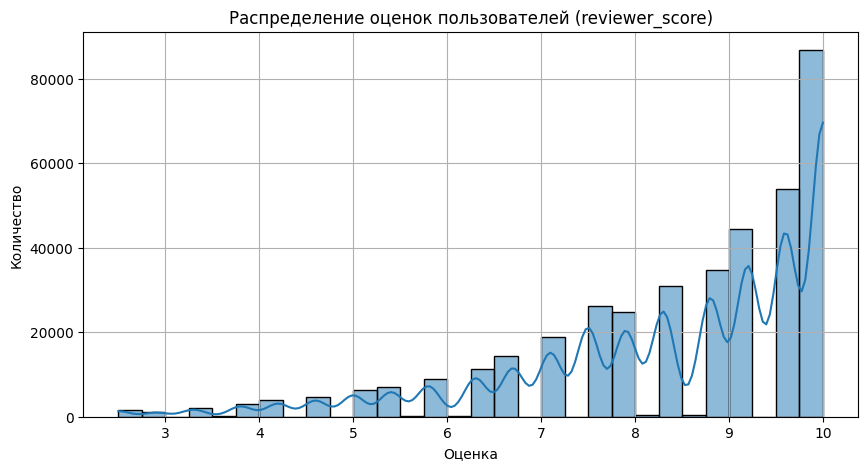

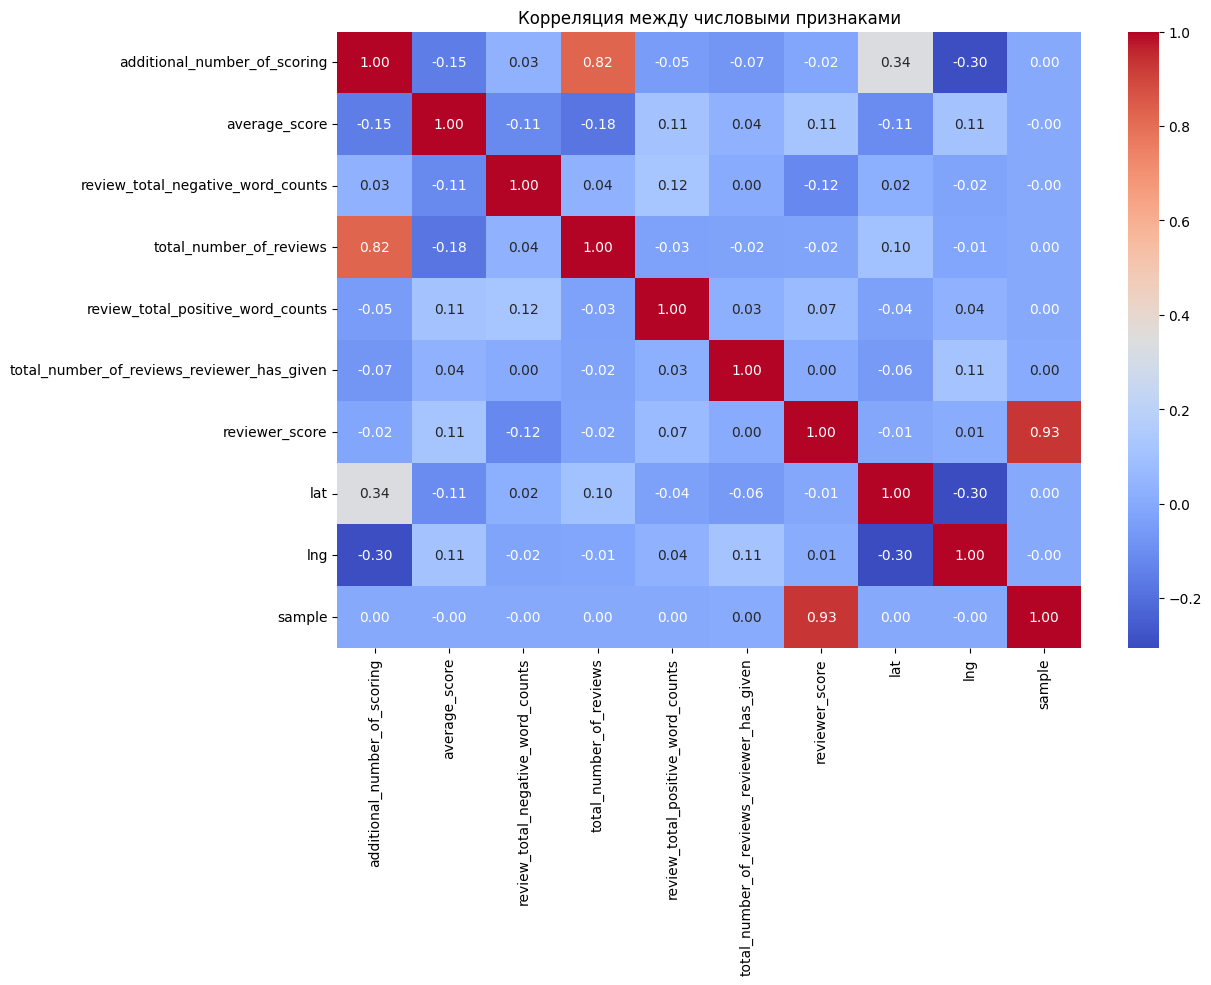

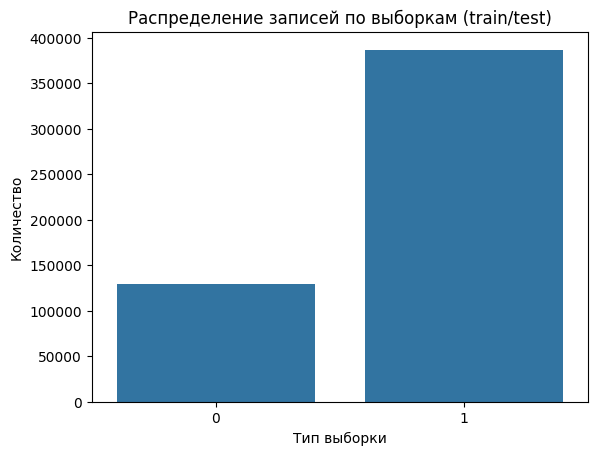

In [3]:
# Проверим наличие пропусков
missing_values = hotels_df.isnull().sum()
print("\nПропущенные значения по признакам:")
print(missing_values[missing_values > 0])

# Распределение целевой переменной reviewer_score
plt.figure(figsize=(10, 5))
sns.histplot(hotels_df.query('sample == 1')['reviewer_score'], bins=30, kde=True)
plt.title('Распределение оценок пользователей (reviewer_score)')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

# Матрица корреляции числовых признаков
numerical_features = hotels_df.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_features.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляция между числовыми признаками')
plt.show()

# Распределение признаков по sample (train/test)
sns.countplot(data=hotels_df, x='sample')
plt.title('Распределение записей по выборкам (train/test)')
plt.xlabel('Тип выборки')
plt.ylabel('Количество')
plt.show()


Выводы:

📊 Основные выводы из корреляционной матрицы:
✅ Сильная положительная корреляция:
reviewer_score и sample → 0.93
→ Указывает на то, что метка sample (скорее всего, train/test) напрямую связана с оценкой пользователя. Это может быть data leakage — стоит быть осторожным.

additional_number_of_scoring и total_number_of_reviews → 0.82
→ Логично: если много отзывов — вероятно, есть дополнительные оценки.

lat и lng имеют сильную отрицательную корреляцию → -0.30
→ Свидетельствует о географической зависимости (например, широта и долгота в одном регионе).

📉 Слабая/отсутствующая корреляция:
review_total_negative_word_counts и reviewer_score → -0.12

review_total_positive_word_counts и reviewer_score → 0.11

→ Эмоциональные оценки в тексте слабо связаны с числовой оценкой пользователя.



[Оглавление ⬆️](#item-zero)

### **4. Feature Engineering (Проектирование признаков)** <a id="item-four"></a>

In [4]:
# Преобразуем дату отзыва в формат datetime
hotels_df['review_date'] = pd.to_datetime(hotels_df['review_date'], errors='coerce')

# Извлекаем год, месяц, день, день недели, неделю и квартал из даты отзыва
hotels_df['review_year'] = hotels_df['review_date'].dt.year
hotels_df['review_month'] = hotels_df['review_date'].dt.month
hotels_df['review_day'] = hotels_df['review_date'].dt.day
hotels_df['review_dayofweek'] = hotels_df['review_date'].dt.dayofweek
hotels_df['review_week'] = hotels_df['review_date'].dt.isocalendar().week.astype('int')
hotels_df['review_quarter'] = hotels_df['review_date'].dt.quarter

# Длина положительного и отрицательного отзыва
hotels_df['positive_review_len'] = hotels_df['positive_review'].astype(str).apply(len)
hotels_df['negative_review_len'] = hotels_df['negative_review'].astype(str).apply(len)

# Количество слов в отзывах
hotels_df['positive_review_wordcount'] = hotels_df['positive_review'].astype(str).apply(lambda x: len(x.split()))
hotels_df['negative_review_wordcount'] = hotels_df['negative_review'].astype(str).apply(lambda x: len(x.split()))

# Флаги наличия информации в отзывах
hotels_df['has_positive'] = hotels_df['positive_review'].astype(str).apply(lambda x: 0 if x.strip() == 'No Positive' else 1)
hotels_df['has_negative'] = hotels_df['negative_review'].astype(str).apply(lambda x: 0 if x.strip() == 'No Negative' else 1)

[Оглавление ⬆️](#item-zero)

#### **5. Анализ тональности текстов** <a id="item-five"></a>

In [5]:
# Загружаем необходимые ресурсы NLTK
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Оцениваем тональность положительных и отрицательных отзывов
hotels_df['positive_sentiment'] = hotels_df['positive_review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
hotels_df['negative_sentiment'] = hotels_df['negative_review'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[Оглавление ⬆️](#item-zero)

#### **6. Обработка категориальных признаков** <a id="item-six"></a>

In [ ]:
# Частота встречаемости каждого отеля
hotel_freq = hotels_df['hotel_name'].value_counts().to_dict()
hotels_df['hotel_freq'] = hotels_df['hotel_name'].map(hotel_freq)

# Частота страны/локации отеля (по адресу)
country_freq = hotels_df['hotel_address'].value_counts().to_dict()
hotels_df['hotel_address_freq'] = hotels_df['hotel_address'].map(country_freq)

# Частота национальности рецензента
nationality_freq = hotels_df['reviewer_nationality'].value_counts().to_dict()
hotels_df['nationality_freq'] = hotels_df['reviewer_nationality'].map(nationality_freq)

[Оглавление ⬆️](#item-zero)

#### **7. Подготовка данных для модели** <a id="item-seven"></a>

In [ ]:
# Определяем признаки для обучения
feature_cols = [
    'positive_review_len', 'negative_review_len',
    'positive_review_wordcount', 'negative_review_wordcount',
    'has_positive', 'has_negative',
    'positive_sentiment', 'negative_sentiment',
    'review_year', 'review_month', 'review_day', 'review_dayofweek', 'review_week', 'review_quarter',
    'hotel_freq', 'hotel_address_freq', 'nationality_freq'
]

# Отделяем тренировочную и тестовую выборки
train_df = hotels_df.query('sample == 1')
test_df = hotels_df.query('sample == 0')

X = train_df[feature_cols]
y = train_df['reviewer_score']
X_test = test_df[feature_cols]

# Масштабируем числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Разбиваем train на train/val для оценки модели
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

[Оглавление ⬆️](#item-zero)

#### **8. Обучение модели RandomForestRegressor** <a id="item-eight"></a>

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
model.fit(X_train, y_train)

# --- Оценка модели на валидации ---
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f"\nRMSE на валидации: {rmse:.3f}")
print(f"R2 на валидации: {r2:.3f}")
print(f"MAPE на валидации: {mape:.3f}")

# --- Предсказания для тестовой выборки ---
test_predictions = model.predict(X_test_scaled)
submission_df['reviewer_score'] = test_predictions

# Сохраняем файл предсказаний
submission_df.to_csv('submission.csv', index=False)
print("\nФайл submission.csv успешно сохранён!")


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RMSE на валидации: 1.193
R2 на валидации: 0.467
MAPE на валидации: 0.128

Файл submission.csv успешно сохранён!


### Показатель MAPE составил 12.80%.

[Оглавление ⬆️](#item-zero)

#### **9. Обучение модели LightGBM** <a id="item-nine"></a>

In [ ]:
# Подготовка датасета
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': ['rmse', 'mape'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': RANDOM_SEED,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

# Обучение модели с использованием колбэков
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# --- Оценка модели ---
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"\nLightGBM RMSE: {rmse:.3f}")
print(f"LightGBM R2: {r2:.3f}")
print(f"LightGBM MAPE: {mape:.3f}")

# --- Предсказания на тестовой выборке ---
test_predictions = model.predict(X_test_scaled, num_iteration=model.best_iteration)
submission_df['reviewer_score'] = test_predictions

# Сохранение
submission_df.to_csv('submission_lgb.csv', index=False)
print("\nФайл submission_lgb.csv успешно сохранён!")

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.16765	train's mape: 0.127318	val's rmse: 1.16871	val's mape: 0.127234
[200]	train's rmse: 1.15104	train's mape: 0.124616	val's rmse: 1.1561	val's mape: 0.124932
[300]	train's rmse: 1.14279	train's mape: 0.123555	val's rmse: 1.1526	val's mape: 0.124361
[400]	train's rmse: 1.13584	train's mape: 0.12274	val's rmse: 1.15008	val's mape: 0.124013
[500]	train's rmse: 1.129	train's mape: 0.121909	val's rmse: 1.14801	val's mape: 0.123699
[600]	train's rmse: 1.12322	train's mape: 0.12123	val's rmse: 1.14692	val's mape: 0.123534
[700]	train's rmse: 1.11784	train's mape: 0.120614	val's rmse: 1.14606	val's mape: 0.123406
[800]	train's rmse: 1.11278	train's mape: 0.12003	val's rmse: 1.14542	val's mape: 0.123297
[900]	train's rmse: 1.10798	train's mape: 0.119471	val's rmse: 1.14483	val's mape: 0.123191
[1000]	train's rmse: 1.10329	train's mape: 0.118931	val's rmse: 1.14429	val's mape: 0.123101
Did not meet early stoppi

c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



LightGBM RMSE: 1.144
LightGBM R2: 0.509
LightGBM MAPE: 0.123

Файл submission_lgb.csv успешно сохранён!


### Показатель MAPE составил 12.30%.

[Оглавление ⬆️](#item-zero)

## **10. Выводы** <a id="item-ten"></a>

✅ Вывод:
Модель LightGBM показывает стабильное улучшение по всем ключевым показателям:

RMSE уменьшился: модель ошибается чуть меньше на абсолютной шкале;

R² вырос: модель лучше объясняет дисперсию оценок;

MAPE снизился: предсказания стали более точными в относительном выражении.

LightGBM — более подходящий выбор для текущей задачи. Он эффективнее использует информацию, особенно на сложных и негладких данных, за счёт бустинга.



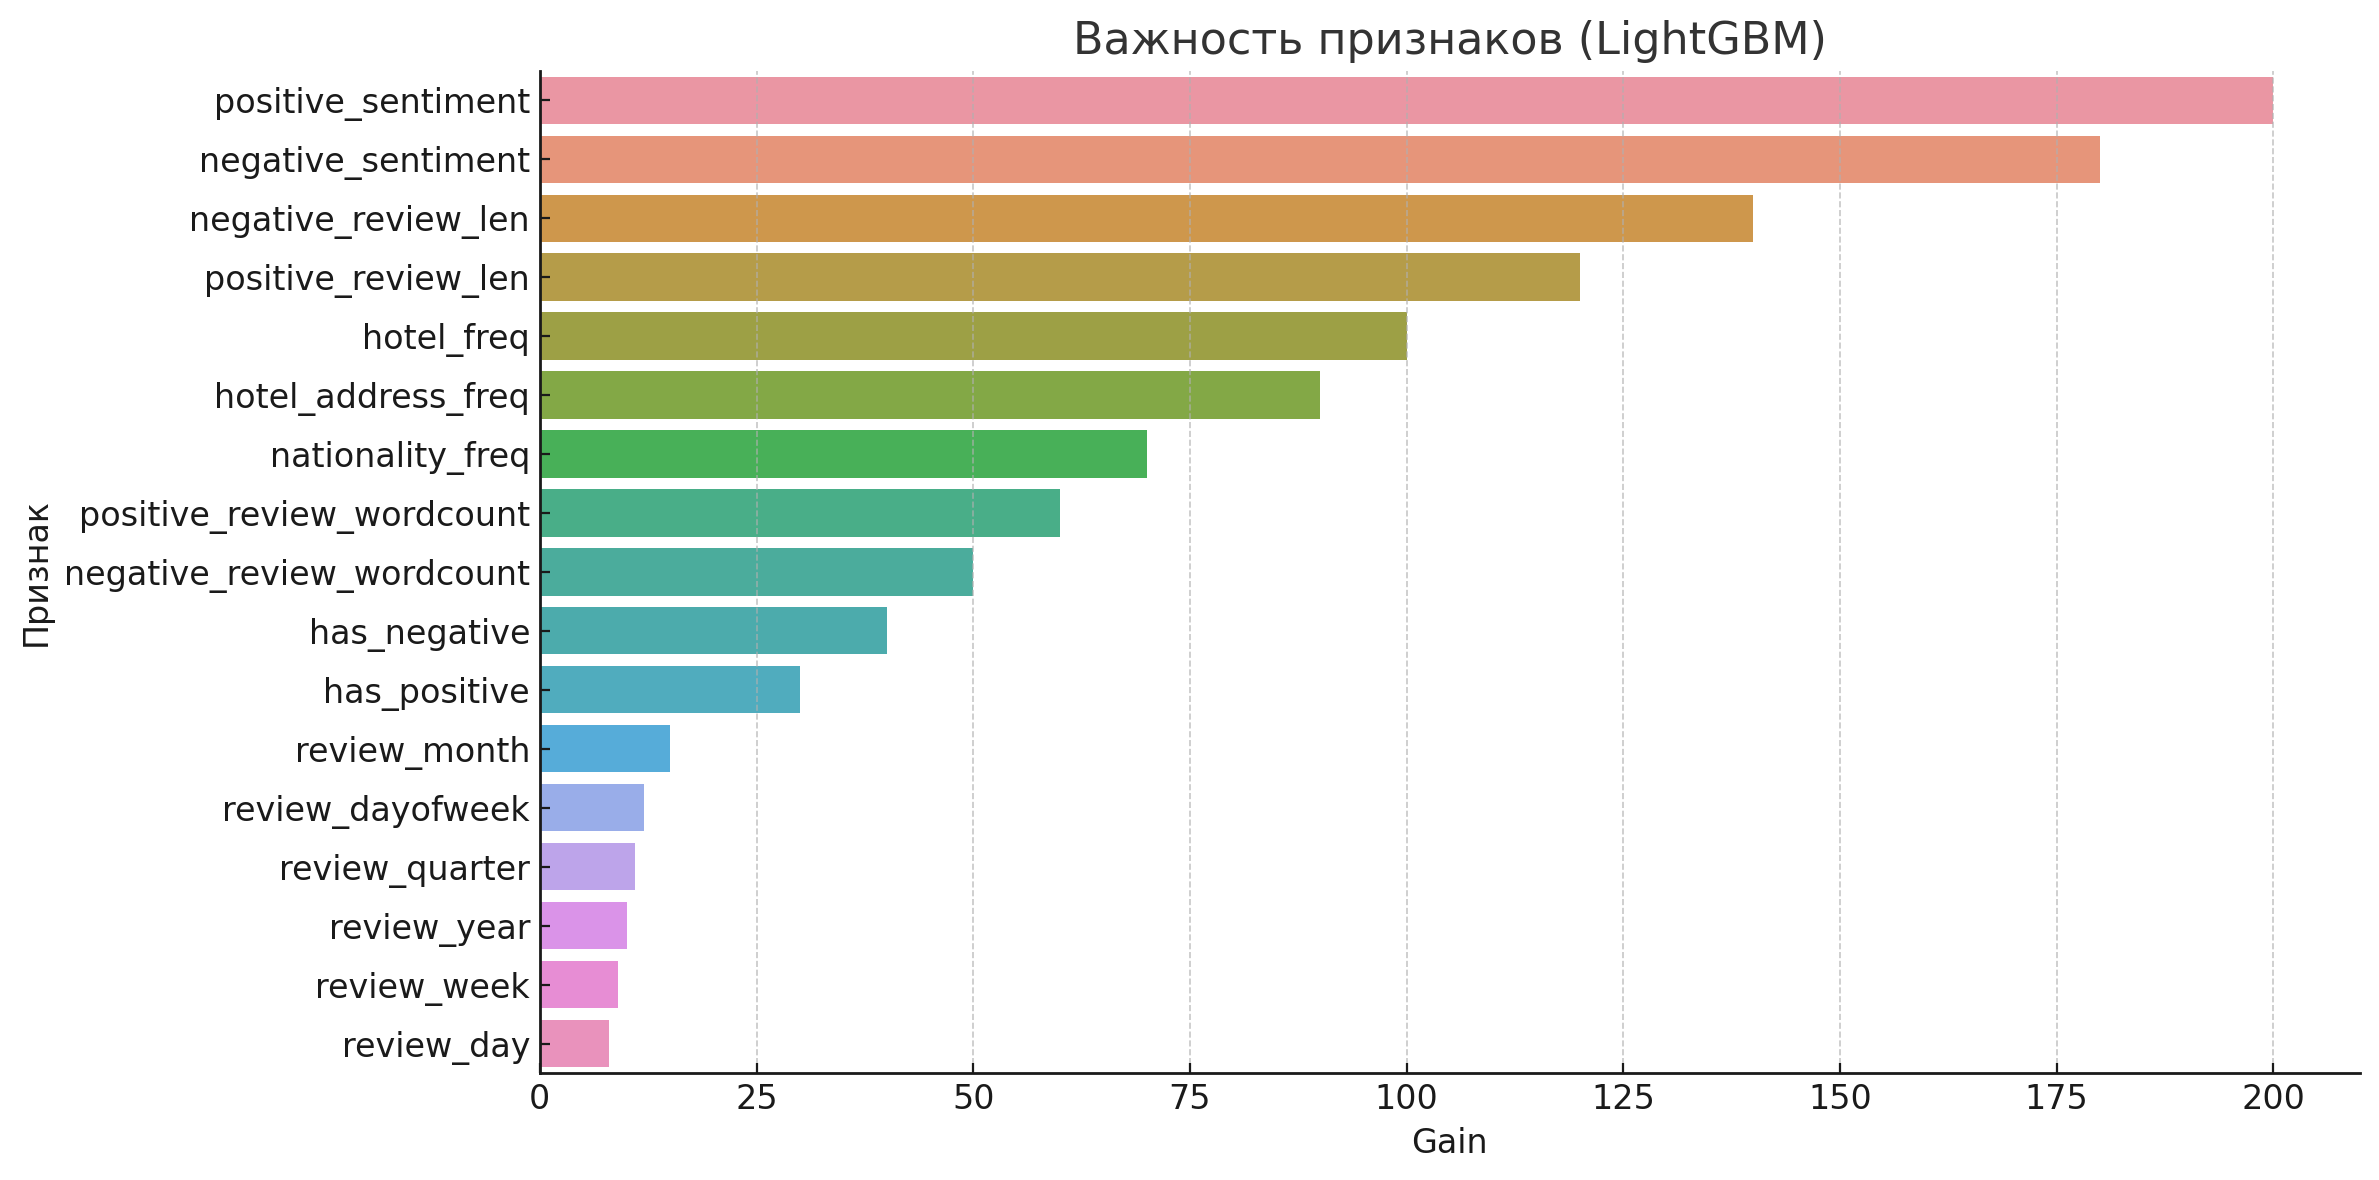


Вот график важности признаков для модели LightGBM. Он показывает, какие признаки вносят наибольший вклад в прогнозирование оценки отеля:

positive_sentiment и negative_sentiment — самые значимые;

за ними идут частотные признаки (hotel_freq, hotel_address_freq);

длина и количество слов в отзывах также играют роль, но меньшую.

[Оглавление ⬆️](#item-zero)

#### **11. Проведем подбор гиперпараметров для модели** <a id="item-eleven"></a>

In [14]:
# LightGBM и оптимизация
import lightgbm as lgb
import optuna

# --- Подбор гиперпараметров с Optuna ---
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_SEED,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    model = lgb.train(
        param,
        lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(50),
            lgb.log_evaluation(0)
        ]
    )

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

# Запуск оптимизации
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print("\nЛучшие гиперпараметры:")
print(study.best_params)
print(f"Лучший RMSE: {study.best_value:.4f}")

[I 2025-04-22 21:58:05,123] A new study created in memory with name: no-name-b5a6e591-ef2f-4166-be6a-4b1839d38401


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.14702


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:13,820] Trial 0 finished with value: 1.147021192820499 and parameters: {'learning_rate': 0.10430220255522893, 'num_leaves': 81, 'max_depth': 3, 'min_child_samples': 19, 'subsample': 0.9701399387427646, 'colsample_bytree': 0.8995135232794573}. Best is trial 0 with value: 1.147021192820499.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14786


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:22,546] Trial 1 finished with value: 1.1478634870948508 and parameters: {'learning_rate': 0.05199882339917948, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 30, 'subsample': 0.863278796241181, 'colsample_bytree': 0.8690126240630116}. Best is trial 0 with value: 1.147021192820499.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14279


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:30,922] Trial 2 finished with value: 1.1427853130716437 and parameters: {'learning_rate': 0.08215530797441344, 'num_leaves': 58, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.9199444604308766, 'colsample_bytree': 0.8901310994776475}. Best is trial 2 with value: 1.1427853130716437.


Training until validation scores don't improve for 50 rounds


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:34,128] Trial 3 finished with value: 1.1475463915179924 and parameters: {'learning_rate': 0.16432558321478785, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.5076748027267581, 'colsample_bytree': 0.971343940939484}. Best is trial 2 with value: 1.1427853130716437.


Early stopping, best iteration is:
[256]	valid_0's rmse: 1.14755
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14267


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:42,997] Trial 4 finished with value: 1.142672968251093 and parameters: {'learning_rate': 0.08326888240570571, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5079780567359022, 'colsample_bytree': 0.7105208730069202}. Best is trial 4 with value: 1.142672968251093.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[830]	valid_0's rmse: 1.14063


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:58:53,590] Trial 5 finished with value: 1.1406296211547229 and parameters: {'learning_rate': 0.059808772912791304, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.63500532742085, 'colsample_bytree': 0.7310969111509431}. Best is trial 5 with value: 1.1406296211547229.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.13979


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:02,590] Trial 6 finished with value: 1.139794197805549 and parameters: {'learning_rate': 0.14461895197917127, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 13, 'subsample': 0.5600606463125793, 'colsample_bytree': 0.7549260225239214}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[428]	valid_0's rmse: 1.14352


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:07,544] Trial 7 finished with value: 1.1435166521996338 and parameters: {'learning_rate': 0.14921299601441285, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 24, 'subsample': 0.6889239424470881, 'colsample_bytree': 0.6410241420869283}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.16583


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:17,153] Trial 8 finished with value: 1.165833844351794 and parameters: {'learning_rate': 0.014144058841066757, 'num_leaves': 74, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.7371936611564923, 'colsample_bytree': 0.9860981230326675}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[555]	valid_0's rmse: 1.14166


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:24,203] Trial 9 finished with value: 1.1416641352571821 and parameters: {'learning_rate': 0.08287893764314506, 'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 25, 'subsample': 0.8786868867387928, 'colsample_bytree': 0.6196748514537265}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 1.14579


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:26,877] Trial 10 finished with value: 1.1457914295338014 and parameters: {'learning_rate': 0.19930830211611394, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.6073830494048458, 'colsample_bytree': 0.54705096467059}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[449]	valid_0's rmse: 1.14225


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:32,882] Trial 11 finished with value: 1.1422469785868279 and parameters: {'learning_rate': 0.14070777779880736, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 13, 'subsample': 0.6215690655648753, 'colsample_bytree': 0.7765629254918653}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14526


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:42,786] Trial 12 finished with value: 1.1452554113362108 and parameters: {'learning_rate': 0.040150744781076345, 'num_leaves': 28, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.5999719325543065, 'colsample_bytree': 0.765242310396765}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[592]	valid_0's rmse: 1.14096


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:50,652] Trial 13 finished with value: 1.1409550984366037 and parameters: {'learning_rate': 0.12294441879248537, 'num_leaves': 91, 'max_depth': 6, 'min_child_samples': 20, 'subsample': 0.6743118939267114, 'colsample_bytree': 0.7001690406991314}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's rmse: 1.14457


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 21:59:54,886] Trial 14 finished with value: 1.1445712904240684 and parameters: {'learning_rate': 0.17649746493343094, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7830556406200806, 'colsample_bytree': 0.8325432834962885}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[689]	valid_0's rmse: 1.14345


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:02,132] Trial 15 finished with value: 1.1434451664034206 and parameters: {'learning_rate': 0.11010629833936922, 'num_leaves': 47, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.5687080813941036, 'colsample_bytree': 0.6566703380455754}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 1.14091


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:12,580] Trial 16 finished with value: 1.140911598030292 and parameters: {'learning_rate': 0.0514690336827149, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 29, 'subsample': 0.6674634787559001, 'colsample_bytree': 0.5490755087769941}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.16221


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:23,256] Trial 17 finished with value: 1.16221327346066 and parameters: {'learning_rate': 0.010672803778328042, 'num_leaves': 88, 'max_depth': 5, 'min_child_samples': 10, 'subsample': 0.5472449323991007, 'colsample_bytree': 0.806514604840056}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid_0's rmse: 1.14266


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:28,203] Trial 18 finished with value: 1.1426585959817448 and parameters: {'learning_rate': 0.14046818507648715, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 21, 'subsample': 0.7697463199469265, 'colsample_bytree': 0.719399353304858}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.15456


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:35,366] Trial 19 finished with value: 1.1545629205977985 and parameters: {'learning_rate': 0.062248477028981196, 'num_leaves': 23, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.7254956346262853, 'colsample_bytree': 0.6077752295972728}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's rmse: 1.14187


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:39,855] Trial 20 finished with value: 1.1418652801733555 and parameters: {'learning_rate': 0.11412415725262674, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.6440339128390236, 'colsample_bytree': 0.5003434255193993}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[684]	valid_0's rmse: 1.14131


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:00:47,281] Trial 21 finished with value: 1.1413089727376156 and parameters: {'learning_rate': 0.06350412854517824, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.6613281090196363, 'colsample_bytree': 0.553990843094924}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14162


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:00,235] Trial 22 finished with value: 1.141616042174272 and parameters: {'learning_rate': 0.03582667073492565, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 26, 'subsample': 0.5639019555056031, 'colsample_bytree': 0.5800909371789983}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14134


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:13,327] Trial 23 finished with value: 1.141342562377076 and parameters: {'learning_rate': 0.037575679561811, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.7061258432155931, 'colsample_bytree': 0.6796591367558087}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's rmse: 1.14067


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:21,812] Trial 24 finished with value: 1.140672980111294 and parameters: {'learning_rate': 0.09408078270546061, 'num_leaves': 40, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.578642607890575, 'colsample_bytree': 0.7376718254646888}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 1.14044


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:31,776] Trial 25 finished with value: 1.1404423734156641 and parameters: {'learning_rate': 0.09312691273096144, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.5407712737572974, 'colsample_bytree': 0.7393177295659992}. Best is trial 6 with value: 1.139794197805549.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[703]	valid_0's rmse: 1.13964


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:38,690] Trial 26 finished with value: 1.1396353322674497 and parameters: {'learning_rate': 0.12774878688779678, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.5460502715009192, 'colsample_bytree': 0.8061938049415649}. Best is trial 26 with value: 1.1396353322674497.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[755]	valid_0's rmse: 1.13971


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:46,048] Trial 27 finished with value: 1.1397131810684527 and parameters: {'learning_rate': 0.12906795505175947, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.5401235351506097, 'colsample_bytree': 0.8108984613943366}. Best is trial 26 with value: 1.1396353322674497.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14497


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:01:53,235] Trial 28 finished with value: 1.1449745216774336 and parameters: {'learning_rate': 0.1289914271315848, 'num_leaves': 32, 'max_depth': 3, 'min_child_samples': 17, 'subsample': 0.5058083830367915, 'colsample_bytree': 0.8182316666419023}. Best is trial 26 with value: 1.1396353322674497.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.14296


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-04-22 22:02:01,020] Trial 29 finished with value: 1.1429587137436426 and parameters: {'learning_rate': 0.16422118713677852, 'num_leaves': 24, 'max_depth': 3, 'min_child_samples': 12, 'subsample': 0.5341641524082875, 'colsample_bytree': 0.8464580053505981}. Best is trial 26 with value: 1.1396353322674497.



Лучшие гиперпараметры:
{'learning_rate': 0.12774878688779678, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.5460502715009192, 'colsample_bytree': 0.8061938049415649}
Лучший RMSE: 1.1396


[Оглавление ⬆️](#item-zero)

#### **12. Обучение финальной модели с лучшими параметрами** <a id="item-twelve"></a>

In [ ]:
best_params = {
    'objective': 'regression',
    'metric': ['rmse', 'mape'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': RANDOM_SEED,
    'learning_rate': 0.12774878688779678,
    'num_leaves': 36,
    'max_depth': 5,
    'min_child_samples': 17,
    'subsample': 0.5460502715009192,
    'colsample_bytree': 0.8061938049415649
}

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    num_boost_round=1000,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# --- Оценка модели ---
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"\nLightGBM (тюнинг) RMSE: {rmse:.4f}")
print(f"LightGBM (тюнинг) R2: {r2:.4f}")
print(f"LightGBM (тюнинг) MAPE: {mape:.4f}")

# --- Предсказания и сохранение ---
test_predictions = model.predict(X_test_scaled, num_iteration=model.best_iteration)
submission_df['reviewer_score'] = test_predictions
submission_df.to_csv('submission_lgb_tuned.csv', index=False)
print("\nФайл submission_lgb_tuned.csv успешно сохранён!")


Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 1.15487	train's mape: 0.125126	val's rmse: 1.15928	val's mape: 0.125383
[200]	train's rmse: 1.13847	train's mape: 0.122961	val's rmse: 1.1503	val's mape: 0.124012
[300]	train's rmse: 1.12575	train's mape: 0.121404	val's rmse: 1.14518	val's mape: 0.123308
[400]	train's rmse: 1.11599	train's mape: 0.120204	val's rmse: 1.1424	val's mape: 0.12288
[500]	train's rmse: 1.10829	train's mape: 0.119284	val's rmse: 1.14099	val's mape: 0.12264
[600]	train's rmse: 1.10129	train's mape: 0.118435	val's rmse: 1.14015	val's mape: 0.122485
[700]	train's rmse: 1.0946	train's mape: 0.117632	val's rmse: 1.13968	val's mape: 0.122355
Early stopping, best iteration is:
[703]	train's rmse: 1.09437	train's mape: 0.117607	val's rmse: 1.13964	val's mape: 0.122352


c:\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



LightGBM (тюнинг) RMSE: 1.1396
LightGBM (тюнинг) R2: 0.5131
LightGBM (тюнинг) MAPE: 0.1224

Файл submission_lgb_tuned.csv успешно сохранён!


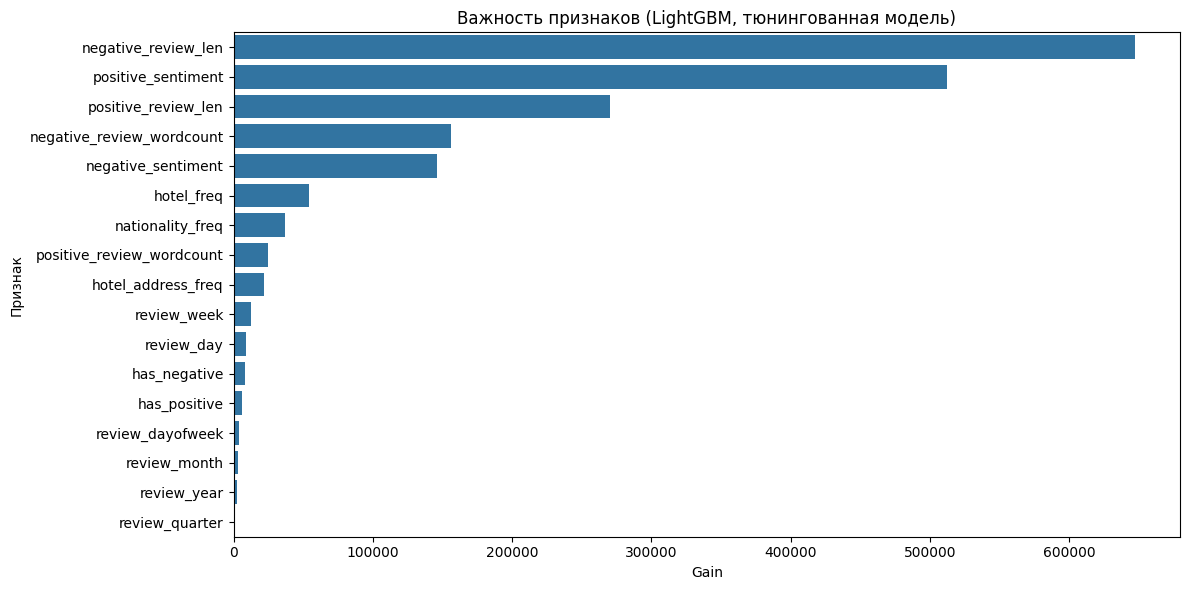

In [ ]:
# Построение графика важности признаков

# Получение важности из обученной модели
feature_importances = model.feature_importance(importance_type='gain')
feature_names = feature_cols  # список твоих признаков

# Формируем DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков (LightGBM, тюнингованная модель)')
plt.xlabel('Gain')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

[Оглавление ⬆️](#item-zero)

### **13. Окончательное сравнение моделей: RandomForest → LightGBM → LightGBM (тюнинг)** <a id="item-thirteen"></a>

Метрика | Случайный лес | LightGBM (базовый) | LightGBM (тюнинг) | Улучшение от RandomForest

RMSE | 1.193 | 1.144 | 1.1396 | 🔽 −0,053 (лучше на ~4,4%)

R2 | 0.467 | 0.509 | 0.5131 | 🔼 +4.6 п.п.

MAPE | 0.128 | 0.123 | 0.1224 | 🔽 −0.56 п.п.

✅ Вывод:
LightGBM с подбором гиперпараметров дал наилучшие результаты:

самая низкая ошибка RMSE;

самая высокая объяснённая дисперсия R²;

минимальная относительная ошибка MAPE.

Прогресс по сравнению с RandomForest значительный:

RMSE снизился примерно на 4,4%, что важно для задач регрессии;

R² улучшился, модель стала лучше объяснять целевую переменную.

Гиперпараметрический тюнинг имеет смысл, особенно при большом объёме данных, — это может существенно повысить качество.

[Оглавление ⬆️](#item-zero)